Let's try out a very basic LSTM. There are plenty of examples around that use LSTM for things like stock market prediction etc, but I had trouble to find a very simple example where you can see what's happening. We give it a sample input with a random 0/1 sequence and want a 2-lag: the LSTM should memorize the last two values and output the next to last.

As [this explains](https://www.damienpontifex.com/2017/12/06/understanding-tensorflows-rnn-inputs-outputs-and-shapes/), the LSTM input has three dimensions: the batch size, the sequence size and the number of features. Compare also [Recurrent Neural Networks (RNNs) with Keras](https://ekababisong.org/gcp-ml-seminar/keras/#recurrent-neural-networks-rnns-with-keras). I assume you cannot use 2 dimensional (sequence size + features) since that'd be computationally inefficient.

In [1]:
#@title Imports and utilities {display-mode: "form"}


import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import functools
import itertools
import time
import os
import datetime

print([tf.__version__, pd.__version__, sns.__version__ ,plt.matplotlib.__version__,np.__version__])


# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, min_delta=0.001, verbose=1)
terminate_nan = keras.callbacks.TerminateOnNaN()

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.semilogy(hist['epoch'], hist['loss'], label='Train Error')
    # plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    # plt.ylim([0,5])
    plt.legend()
    
def meanAndVariance(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  means = y_pred[..., 0::2]
  variances = y_pred[..., 1::2]
  res = K.square(means - y_true) + K.square(variances - K.square(means - y_true))
  return K.mean(res, axis=-1)


['1.14.0', '0.24.2', '0.9.0', '3.0.3', '1.16.4']


We generate a batch of random sequences and roll the sequence by one to get the expected result, as visible in the printed examples.

In [2]:
def shiftedSequenceInput(seqlength,numsequences):
  sequences = [np.random.choice([0,1],seqlength)*2.0-1 for _ in range(numsequences)]
  # sequences = [np.random.randn(seqlength)*2.0-1 for _ in range(numsequences)]
  shifted = [np.roll(x,2) for x in sequences]
  #print(sequences)
  #print(shifted)
  return (np.asarray(sequences).reshape([numsequences,seqlength,1]), np.asarray(shifted).reshape([numsequences,seqlength,1]))

seqlength=128
data=shiftedSequenceInput(seqlength,512)
print(data[0].shape)
print(data[0][3].T)
print(data[1][3].T)


(512, 128, 1)
[[ 1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.
   1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.
  -1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.
  -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.
   1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.
   1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.
   1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
  -1.  1.]]
[[-1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.
  -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.
   1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1.
  -1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.
   1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.
  -1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.
   1. -1.  1

A cross correlation plot between input and expected output on example no. 3 from the batch nicely shows a maximum at 1 (our shift).

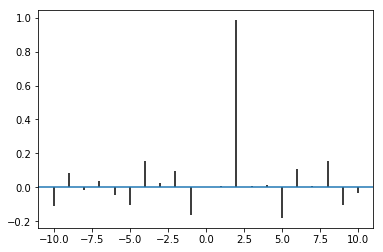

In [3]:
plt.xcorr(data[1][3].T[0], data[0][3].T[0],maxlags=10)
plt.show()

For the LSTM we need return_sequences=True since we have an expected output for every step - you could also train with just the expected final output.

In [0]:
model = tf.keras.Sequential()
l=tf.keras.layers.LSTM(5,
                       # dropout=0.2, recurrent_dropout=0.2,
                               return_sequences=True)
model.add(l)
model.add(tf.keras.layers.Dense(1))

model.compile(loss=tf.losses.mean_squared_error, optimizer='adam', metrics=[tf.losses.mean_squared_error])

%time history=model.fit(data[0], data[1] , steps_per_epoch=10, epochs=300, verbose=0, callbacks=[PrintDot()])

print(history.history['loss'][-1])
plot_history(history)
# print(datetime.datetime.now())
model.summary()
print(history.history)

W0707 14:42:47.727120 140207605532544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0707 14:42:48.162747 140207605532544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



.................................

The loss doesn't get any lower because there is a fundamental problem with the loss function. The first two outputs on each sequence are always off, since there is no history the network can draw from. But the loss function counts these, too. So we have to wrap the loss function to skip the first values:

In [0]:
def skipForLoss(loss, skip):
  def skipping(y_true, y_pred): 
    return loss(y_true[:,skip:,::], y_pred[:,skip:,::])
  return skipping

skippedmae = skipForLoss(tf.losses.mean_squared_error, 3)

model.compile(loss=skippedmae, optimizer='adam', metrics=[skippedmae])

%time history=model.fit(data[0], data[1] , steps_per_epoch=10, epochs=200, verbose=0, callbacks=[PrintDot()])

print(history.history['loss'][-1])
plot_history(history)

In [0]:
i=data[0][[3],:,:]
o=data[1][[3],:,:]
p=model.predict(i)
print(i.flatten()[-18:])
print(o.flatten()[-18:])
print(p.flatten()[-18:])

We find that nice spike also at shift 2 in the cross correlation between the input and the prediction.

In [0]:
plt.xcorr(p.flatten(), i.flatten(),maxlags=10)
plt.show()

Out of curiosity: let's see whether the model generalizes to inputs -0.5, 0.5. Obviously not particularily good - we'd need to use examples for this.

In [0]:
i=data[0][[3],:,:]*0.5
o=data[1][[3],:,:]*0.5
p=model.predict(i)
print(i.flatten()[-18:])
print(o.flatten()[-18:])
print(p.flatten()[-18:])
plt.xcorr(p.flatten(), i.flatten(),maxlags=10)
plt.show()

In [0]:
# predicting using a different sequence length
# does not work :-( 
# we get ValueError: Error when checking input: expected lstm_7_input to have shape (128, 1) but got array with shape (64, 1)
data2=shiftedSequenceInput(64,512)
i=data2[0][[3],:,:]
o=data2[1][[3],:,:]
p=model.predict(i)
print(i.flatten()[-18:])
print(o.flatten()[-18:])
print(p.flatten()[-18:])

## Using a generator

I don't like the separation between the data and the labels into different data structures - that makes shuffling difficult. And probably it's better to have many batches if you have lots of data, but that 3 dimensional input format doesn't allow several batches. So we try to use [Model.fit_generator](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit_generator) with a python generator spewing out batches. Each batch is (data,labels) where both data and labels have three dimensions: data[sequencenumber, timestep, inputnumber] (or outputnumber, that is).

Don't ask me why the generator is called 11 times more than steps_per_epoch * epochs.


In [0]:
numberOfGeneratorCalls = 0
def dataGenerator():
  while True:
    global numberOfGeneratorCalls
    numberOfGeneratorCalls = numberOfGeneratorCalls + 1
    
    sequence = np.random.choice([0,1],seqlength)*2.0-1
    expected = np.roll(sequence,2)
    # here, each batch consists of one sequence. That's probably not advisable in practice for efficiency reasons
    yield (sequence.reshape([1,-1,1]), expected.reshape([1,-1,1]))

history = model.fit_generator(dataGenerator(), steps_per_epoch=5, epochs=5, verbose=0)
print(history.history['loss'][-1])

numberOfGeneratorCalls

## Prediction variants

In [0]:
m1 = tf.keras.Sequential()
l1=tf.keras.layers.LSTM(2, 
                        # input_shape=(3,2), # seems not neccesary, but doesn't hurt either
                        return_sequences=True)
m1.add(l1)
m1.add(tf.keras.layers.Dense(5))

m1.compile(loss=tf.losses.mean_squared_error, optimizer='adam', metrics=[tf.losses.mean_squared_error])

# %time history=m1.fit(data[0], data[1] , steps_per_epoch=10, epochs=300, verbose=0, callbacks=[PrintDot()])

d = np.random.randn(4,3,2)  # [sequencenumber, timestep, inputnumber]
l = np.random.randn(4,3,5) # [sequencenumber, timestep, outputnumber]
# m1.fit(d,l)
m1.fit_generator( (x for x in [(d,l)]), steps_per_epoch=1, epochs=1 )
print(m1.predict(d).shape)
print(m1.predict_generator( (x for x in [d,d,d]), steps = 1000 ).shape) # nonsense.

In [0]:
m1.predict(np.random.randn(4,7,2)).shape 
# different sequence length -> OK, except if we give an input_shape

In [0]:
m1.predict(np.random.randn(7,3,2)).shape # different number of batches -> OK

In [0]:
# does not work: different number of inputs
try:
  m1.predict(np.random.randn(4,3,7)).shape
except Exception as e:
  print('OK: got ', type(e), e)
else:
  assert False, "This should throw an IllegalArgumentError"